In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Get the datasets
df1975 = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/eb228490f7d823bfa6458b93db075ca5ccd3ec3d/finch_beaks_1975.csv')

In [3]:
df1975.head()

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [4]:
df1975['year'] = 1975

In [5]:
df1975.rename(columns = {'Beak length, mm':'beak_length','Beak depth, mm':'beak_depth'}, inplace=True)

In [6]:
df2012 = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/b28d5bf65e38460dca7b3c5c0e4d53bdfc1eb905/finch_beaks_2012.csv')

In [7]:
df2012['year'] = 2012

In [8]:
df2012.rename(columns = {'blength':'beak_length','bdepth':'beak_depth'}, inplace=True)

In [9]:
df1975.shape

(403, 5)

In [10]:
df2012.shape

(248, 5)

In [11]:
df = pd.concat([df1975,df2012], axis=0)

In [12]:
df.shape

(651, 5)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651 entries, 0 to 247
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   band         651 non-null    int64  
 1   species      651 non-null    object 
 2   beak_length  651 non-null    float64
 3   beak_depth   651 non-null    float64
 4   year         651 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 30.5+ KB


## EDA of beak depths of Darwin's finches

Text(376.9000000000001, 0.5, 'Beak depth (mm)')

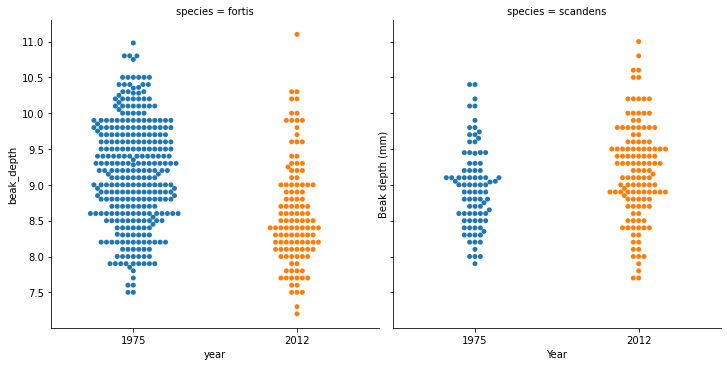

In [14]:
sns.catplot(x='year',y='beak_depth', col='species', data=df, kind='swarm')
plt.xlabel('Year')
plt.ylabel('Beak depth (mm)')

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the Scandens 2012 data set might have a higher mean and bigger variance. For the fortis we see that the 2012 data has a lower mean and a higher variance.

## ECDFs of beak depths for Scandens
While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.

In [15]:
# Create a function to calculate ECDF given a column series
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y  

In [46]:
bd_1975 = df.query('year == 1975 and species == "scandens"').beak_depth.reset_index(drop=True)
bd_2012 = df.query('year == 2012 and species == "scandens"').beak_depth.reset_index(drop=True)
bd_1975

0     8.40
1     8.80
2     8.40
3     8.00
4     7.90
      ... 
82    9.45
83    9.05
84    8.75
85    9.45
86    8.35
Name: beak_depth, Length: 87, dtype: float64

In [47]:
# Compute ECDFs for the beak lengths for each year
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

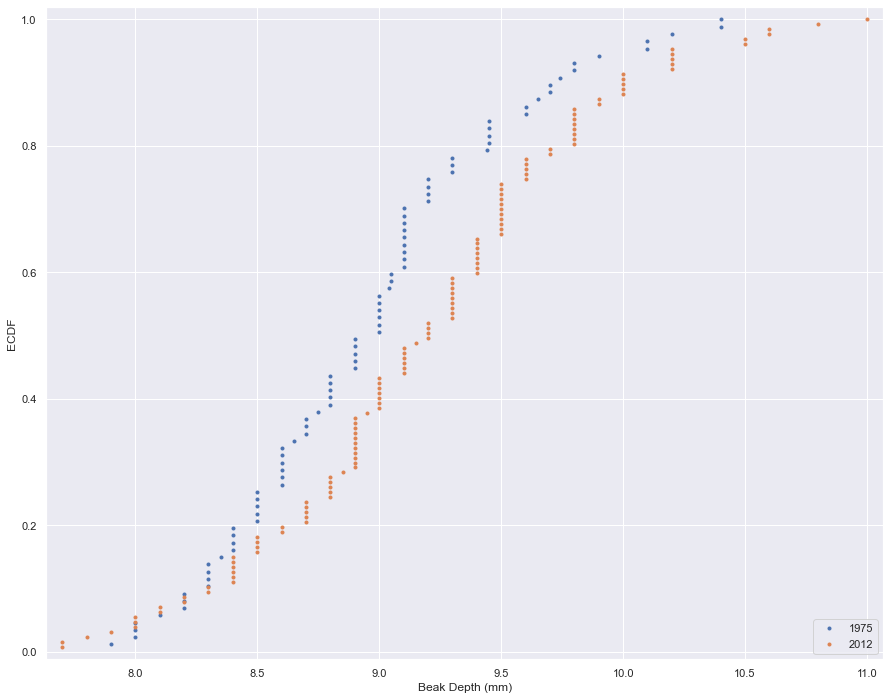

In [48]:
# Plot the ECDFs
sns.set()
fig, ax = plt.subplots(figsize=(15,12))
plt.plot(x_1975, y_1975, marker='.', linestyle='none', label='1975')
plt.plot(x_2012, y_2012, marker='.', linestyle='none', label='2012')
# Set margins
plt.margins(0.02)
# Label axes and make a legend
plt.xlabel('Beak Depth (mm)')
plt.ylabel('ECDF')
plt.legend(loc='lower right')

The ECDF is much more revealing about the differences than the swamplot. From it we can clearly see the mean of 2012 is much larger.

## Parameter estimates of beak depths for G. scandens

We will estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval using bootstrap replicates functions

### Create functions we will use

In [49]:
# Bootstrap replicate function
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data"""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [50]:
def draw_bs_reps(data, func, size=1):
    """ Draw bootstrap replicates."""
    
    # Initialize array of replicates bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates

In [51]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [52]:
# Compute the difference of the sample means: mean_diff
mean_diff = diff_of_means(bd_2012, bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, size=10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

Text(0, 0.5, 'ECDF')

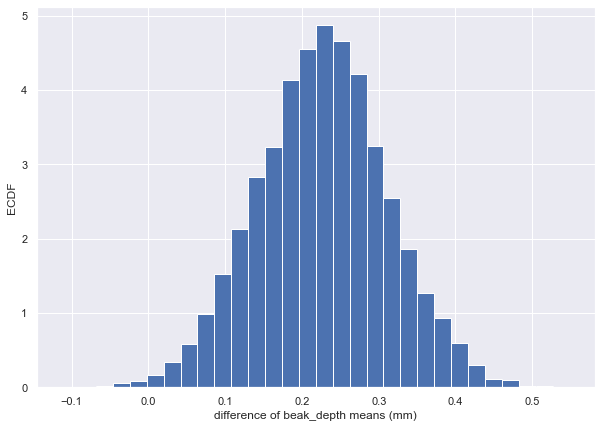

In [53]:
# Plot out the histogram
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(bs_diff_replicates, bins=30, density=True)
plt.xlabel('difference of beak_depth means (mm)')
plt.ylabel('ECDF')

In [54]:
# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5,97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.2262204724409429 mm
95% confidence interval = [0.06033299 0.39464528] mm


## Hypothesis test: Are beaks deeper in 2012?
Our plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten more deep. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [56]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, size=10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_1975 - bs_replicates_2012

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0034


We get a p-value of 0.0034, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.22 mm between the means. You should combine this with the statistical significance. Changing by 0.22 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would be double in only 400 years.

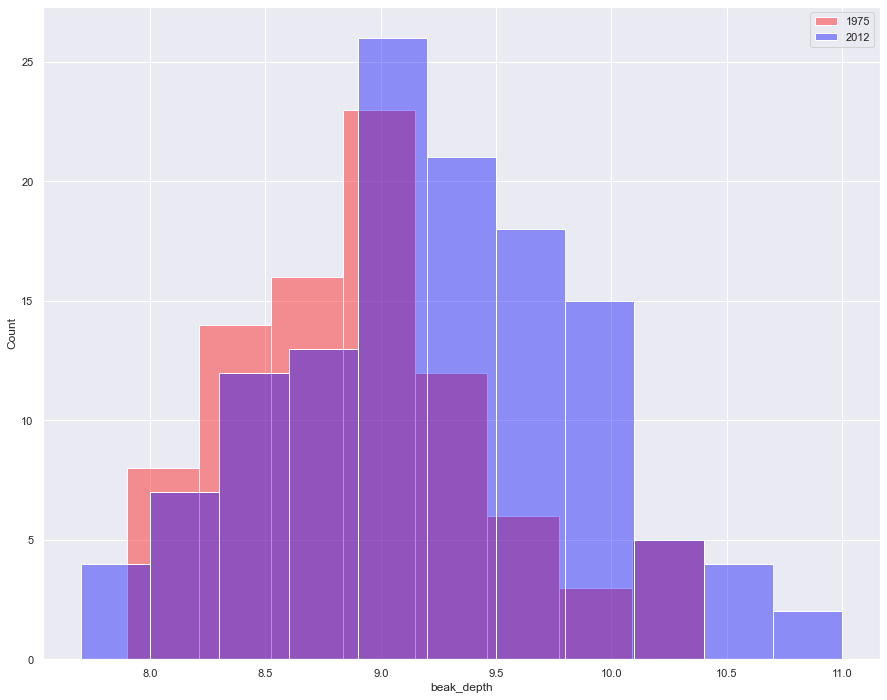

In [57]:
# Plot the histograms overlaying each other to see if we could spot the difference
fig,ax = plt.subplots(figsize=(15,12))
sns.histplot(bd_1975, color='red', alpha=0.4, label='1975')
sns.histplot(bd_2012, color='blue', alpha=0.4, label='2012')
plt.legend(loc='best')

## EDA of beak length and depth

In [58]:
df.head()

,band,species,beak_length,beak_depth,year
0,2,fortis,9.4,8.0,1975
1,9,fortis,9.2,8.3,1975
2,12,fortis,9.5,7.5,1975
3,15,fortis,9.5,8.0,1975
4,305,fortis,11.5,9.9,1975


In [59]:
# Create array of beak lengths for 1975 and 2012 respectively
bl_1975 = df.query('year == "1975" and species == "scandens"').beak_length.reset_index(drop=True)
bl_2012 = df.query('year == "2012" and species == "scandens"').beak_length.reset_index(drop=True)

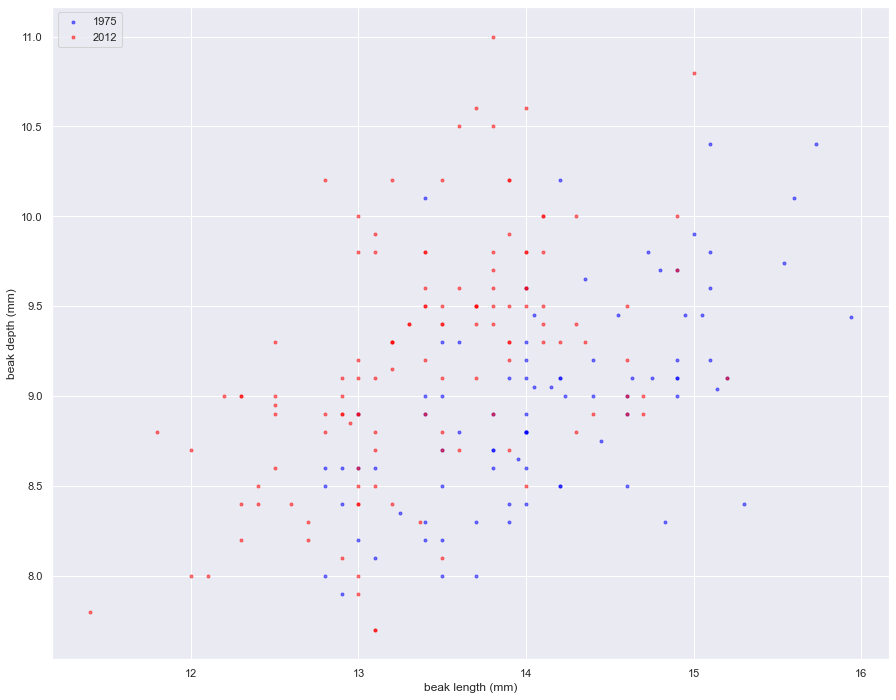

In [61]:
# Make scatter plot of 1975 data
plt.figure(figsize=(15, 12))
plt.scatter(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
plt.scatter(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

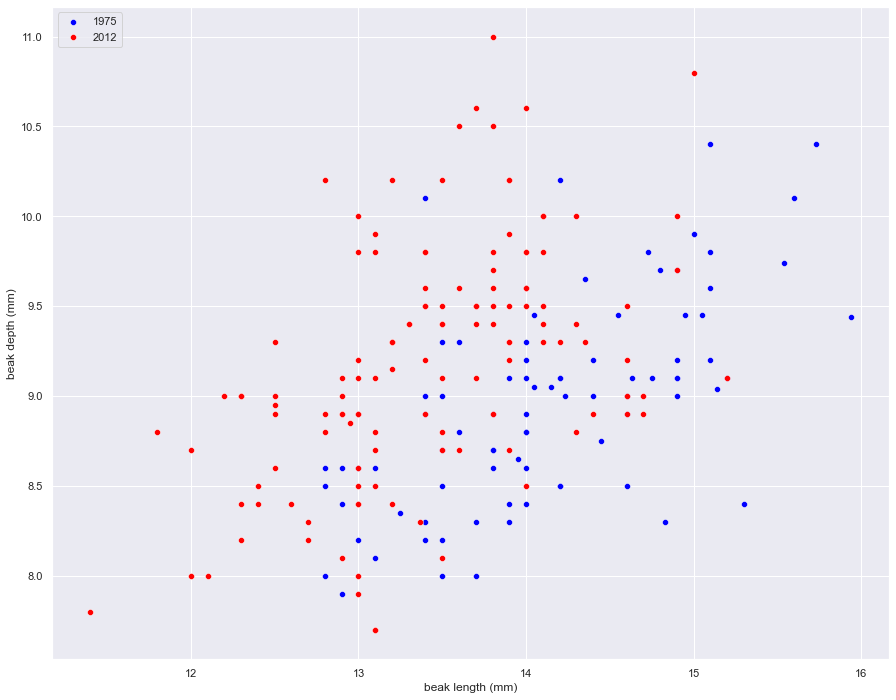

In [62]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.scatterplot(x=bl_1975, y=bd_1975, color='blue', ax=ax)
sns.scatterplot(x=bl_2012, y=bd_2012, color='red', ax=ax)
# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

## Linear regressions

We will perform a linear regression for both the 1975 and 2012 data. Then, perform pairs bootstrap estimates for the regression parameters followed by reporting the 95% confidence intervals on the slope and intercept of the regression line.

### Create a function to perform pairs bootstrap for linear regression 

In [63]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [64]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

In [65]:
# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(bl_1975, bd_1975, size=1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(bl_2012, bd_2012, size=1000)

In [66]:
# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5,97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5,97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5,97.5])

intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5,97.5])


# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.32405944 0.59208612]
1975: intercept = 2.3908752365842263 conf int = [0.64179446 4.37631917]
2012: slope = 0.462630358835313 conf int = [0.32222449 0.59993283]
2012: intercept = 2.9772474982360198 conf int = [1.16922426 4.87704375]


It looks like they have the same slope but different intercepts

### Display the linear regressions from the bootstraps over the scatter plot

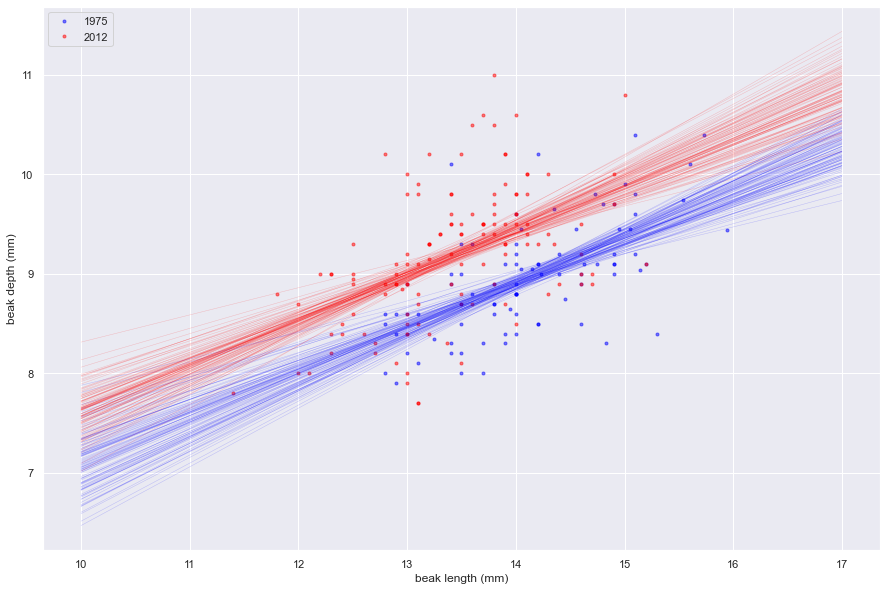

In [69]:
# Make scatter plot of 2012 data
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(bl_1975, bd_1975, marker='.',
        linestyle='none', color='blue', alpha=0.5)
plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

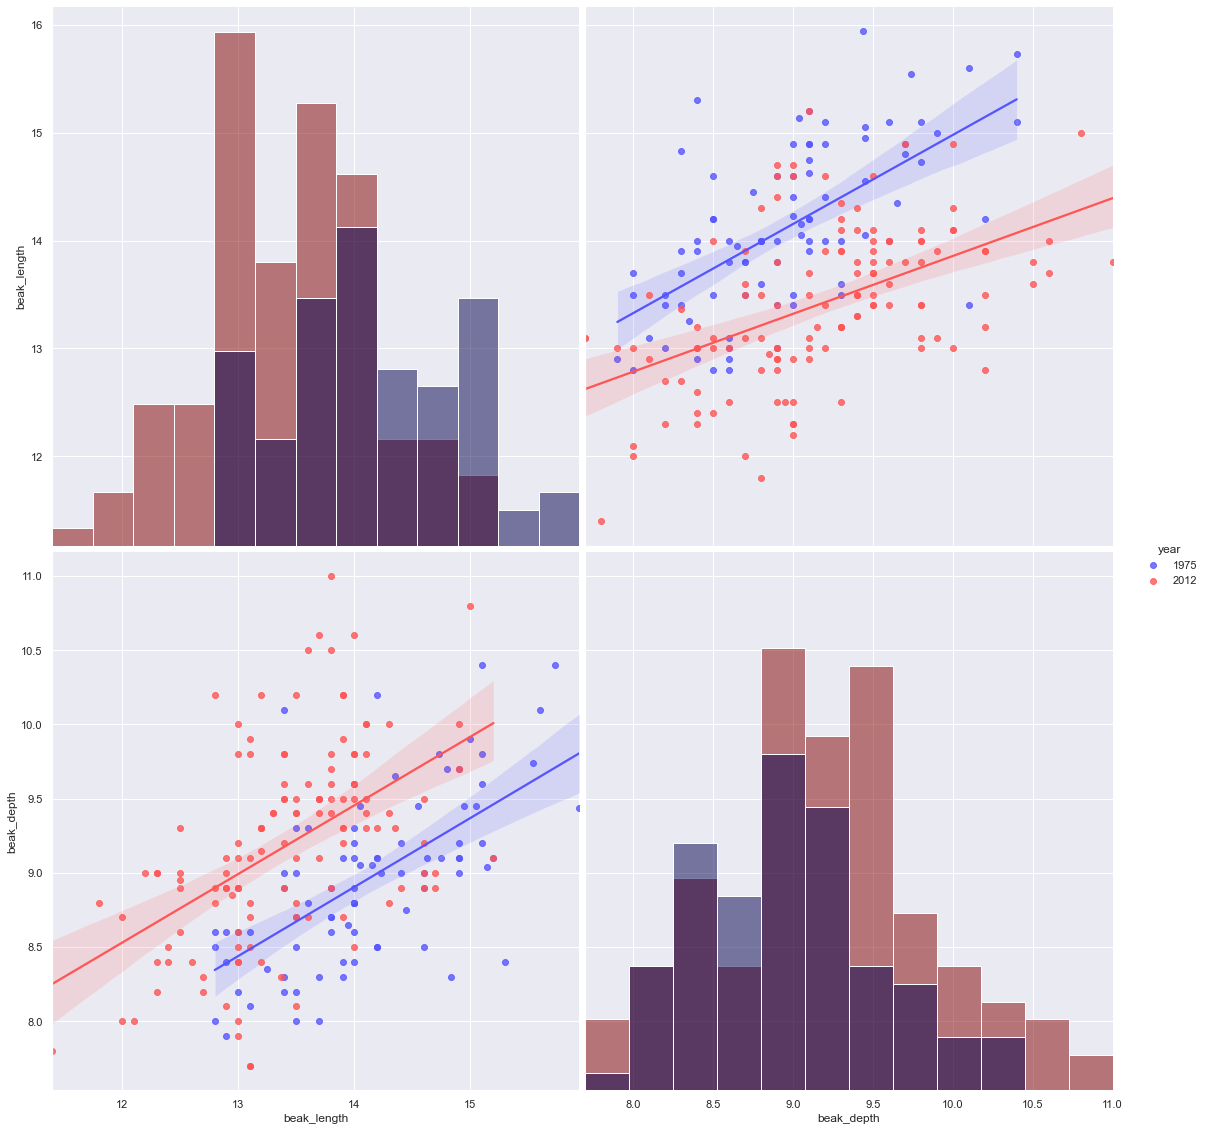

In [82]:
# Another way to do the above in a much more succint method:
sns.set_palette('bright')
sns.pairplot(df.query('species == "scandens"'), vars=['beak_length','beak_depth'],
            kind='reg',
            diag_kind='hist',
            hue='year',
            palette='seismic',
            height=8)

## Beak length to depth ratio
The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

In [84]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5,99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5,99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55657825 1.60104651]
2012: mean ratio = 1.4658342276847778 conf int = [1.44469031 1.48775045]


# Import the heritability data



In [88]:
her_scan = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/7ff772e1f4e99ed93685296063b6e604a334236d/scandens_beak_depth_heredity.csv')

In [92]:
her_scan['species'] = 'scandens'

In [98]:
her_scan.head()

,mid_parent,mid_offspring,species
0,8.3318,8.4190,scandens
1,8.4035,9.2468,scandens
2,8.5317,8.1532,scandens
3,8.7202,8.0089,scandens
4,8.7089,8.2215,scandens


In [101]:
her_scan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mid_parent     130 non-null    float64
 1   mid_offspring  130 non-null    float64
 2   species        130 non-null    object 
dtypes: float64(2), object(1)
memory usage: 3.2+ KB


In [96]:
her_for = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/532cb2fecd1bffb006c79a28f344af2290d643f3/fortis_beak_depth_heredity.csv')

In [97]:
her_for.head()

,Mid-offspr,Male BD,Female BD
0,10.70,10.90,9.3
1,9.78,10.70,8.4
2,9.48,10.70,8.1
3,9.60,10.70,9.8
4,10.27,9.85,10.4


In [102]:
her_for.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mid-offspr  413 non-null    float64
 1   Male BD     413 non-null    float64
 2   Female BD   413 non-null    float64
 3   mid_parent  0 non-null      float64
dtypes: float64(4)
memory usage: 13.0 KB


In [105]:
her_for['mid_parent'] = her_for[['Male BD','Female BD']].mean(axis=1)

In [107]:
her_for.rename(columns ={'Mid-offspr':'mid_offspring'}, inplace=True)

In [116]:
her_for.drop(columns=['Male BD','Female BD'], inplace=True)

In [118]:
her_for['species'] = 'fortis'

In [139]:
hered = pd.concat([her_scan, her_for], axis=0)

In [140]:
hered.head()

,mid_parent,mid_offspring,species
0,8.3318,8.4190,scandens
1,8.4035,9.2468,scandens
2,8.5317,8.1532,scandens
3,8.7202,8.0089,scandens
4,8.7089,8.2215,scandens


In [141]:
# Create arrays for each species for parent and also offspring
bd_parent_scandens = hered.query('species == "scandens"').mid_parent.reset_index(drop=True)
bd_offspring_scandens = hered.query('species == "scandens"').mid_offspring.reset_index(drop=True)
bd_parent_fortis = hered.query('species == "fortis"').mid_parent.reset_index(drop=True)
bd_offspring_fortis = hered.query('species == "fortis"').mid_offspring.reset_index(drop=True)

In [142]:
# Create a melt dataframe in order to do a swarmplot
hered_melt = pd.melt(hered, id_vars=['species'], value_vars=['mid_parent','mid_offspring'],
                    var_name='family', value_name='ratio')

In [144]:
hered_melt.head()

,species,family,ratio
0,scandens,mid_parent,8.3318
1,scandens,mid_parent,8.4035
2,scandens,mid_parent,8.5317
3,scandens,mid_parent,8.7202
4,scandens,mid_parent,8.7089


## EDA on heritability data

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='family', ylabel='ratio'>

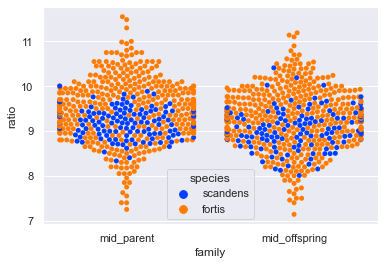

In [147]:
sns.swarmplot(x='family', y='ratio', hue='species', data=hered_melt)

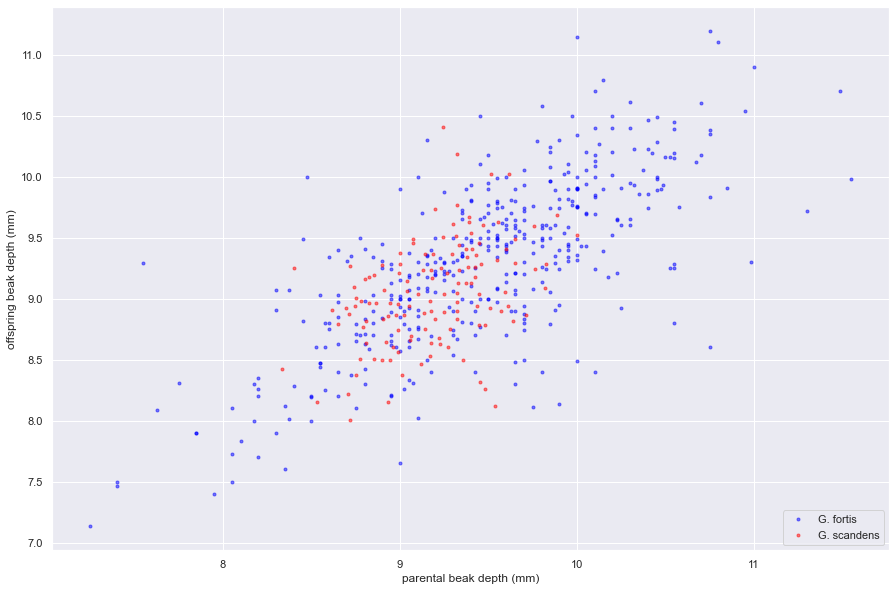

In [125]:
# Make scatter plots
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
plt.xlabel('parental beak depth (mm)')
plt.ylabel('offspring beak depth (mm)')

# Add legend
plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

In [126]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

## Pearson correlation of offspring and parental data

The Pearson correlation coefficient seems like a useful measure of how strongly the beak depth of parents are inherited by their offspring. Then we will compute the Pearson correlation coefficient between parental and offspring beak depths for G. scandens followed by the same for G. fortis. 

In [127]:
# Create a function to return the Pearson Correlation coefficient given two variables
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [128]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)
# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens,pearson_r, size=1000)

bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5,97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5,97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401258 [0.25802237 0.53356393]
G. fortis: 0.7283412395518487 [0.66823855 0.78082804]


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

# Measuring heritability
Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone.

We will therefore estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

In [129]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0][1] / covariance_matrix[0][0]

In [130]:
# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5,97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5,97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685982 [0.34013035 0.73868589]
G. fortis: 0.7229051911438156 [0.64712079 0.79666022]


Here again, we see that G. fortis has stronger heritability than G. scandens. This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.

## Is beak depth heritable at all in G. scandens?

The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. We will test that hypothesis here. To do this, we will do a pairs permutation test.

In [131]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)

p-val = 0.0


We get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis.

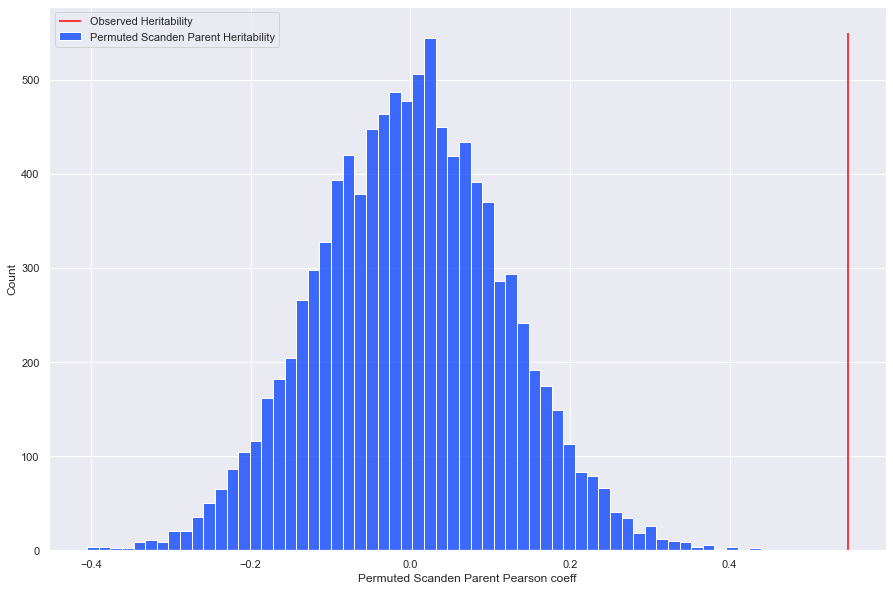

In [138]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(perm_replicates, label='Permuted Scanden Parent Heritability')
plt.vlines(x=heritability_scandens, ymin=0, ymax=550, color='red', label="Observed Heritability")
plt.xlabel('Permuted Scanden Parent Pearson coeff')
plt.ylabel('Count')
plt.legend(loc='upper left')